# Cálculo del quemado de un EE.CC. a partir de las cuentas neutrónicas del SICOM-NG-FA y otras variables de interés.

In [1]:
import pandas as pd

df = pd.read_csv("DataSet.csv", sep=';', index_col="ind")
df.head()

,EECC,TipoEC,Muestra,Cnn,T(ms),Cnn/s,Ciclos,Enf(mes),Enr(%),Mwd/TnU
ind,,,,,,,,,,
1,BL09,MAEF,1,32458,146916,220.94,3,127,4.697,44082
2,BL09,MAEF,2,39967,150917,264.84,3,127,4.697,46265
3,BL09,MAEF,3,39438,145916,270.29,3,127,4.697,46517
4,BL09,MAEF,4,30342,145930,207.93,3,127,4.697,43374
5,BL09,MAEF,5,30361,140921,215.46,3,127,4.697,43788


### Codificación de la categoría TipoEC

In [2]:
# df.TipoEC.value_counts()

dummies = pd.get_dummies(df['TipoEC'])
df = pd.concat([df, dummies], axis = 1)
df.drop('TipoEC', axis=1, inplace=True)
df.head()

,EECC,Muestra,Cnn,T(ms),Cnn/s,Ciclos,Enf(mes),Enr(%),Mwd/TnU,AEF,MAEF,OFA,STD
ind,,,,,,,,,,,,,
1,BL09,1,32458,146916,220.94,3,127,4.697,44082,0,1,0,0
2,BL09,2,39967,150917,264.84,3,127,4.697,46265,0,1,0,0
3,BL09,3,39438,145916,270.29,3,127,4.697,46517,0,1,0,0
4,BL09,4,30342,145930,207.93,3,127,4.697,43374,0,1,0,0
5,BL09,5,30361,140921,215.46,3,127,4.697,43788,0,1,0,0


### Reordeno los datos y elimino varias columnas [Cnn y T(ms), porque son combinación lineal de Cnn/s; AEF, porque es la ausencia de MAEF, OFA y STD simultáneamente]

In [3]:
df = df [['EECC', 'Muestra', 'MAEF', 'OFA', 'STD', 'Cnn/s', 'Ciclos', 'Enf(mes)', 'Enr(%)', 'Mwd/TnU']]
df.head()

,EECC,Muestra,MAEF,OFA,STD,Cnn/s,Ciclos,Enf(mes),Enr(%),Mwd/TnU
ind,,,,,,,,,,
1,BL09,1,1,0,0,220.94,3,127,4.697,44082
2,BL09,2,1,0,0,264.84,3,127,4.697,46265
3,BL09,3,1,0,0,270.29,3,127,4.697,46517
4,BL09,4,1,0,0,207.93,3,127,4.697,43374
5,BL09,5,1,0,0,215.46,3,127,4.697,43788


### Tipificación y discretización de los datos

In [4]:
from scipy import stats
from sklearn.preprocessing import KBinsDiscretizer


# Creo una función para tipificar las columnas del df
def TipificarColumnas(dataframe, column):
    dataframe[column] = dataframe[column].astype(float)
    dataframe[column] = stats.zscore(dataframe[column])
    return dataframe

# Copio el df para no modificar el original y tipifico las cinco últimas columnas
data = df.copy()
for column in data.columns[-5:]:
    data = TipificarColumnas(data, column)


data.head()

,EECC,Muestra,MAEF,OFA,STD,Cnn/s,Ciclos,Enf(mes),Enr(%),Mwd/TnU
ind,,,,,,,,,,
1,BL09,1,1,0,0,-0.103873,0.536875,-0.602062,0.871258,0.273655
2,BL09,2,1,0,0,0.218885,0.536875,-0.602062,0.871258,0.532389
3,BL09,3,1,0,0,0.258954,0.536875,-0.602062,0.871258,0.562256
4,BL09,4,1,0,0,-0.199524,0.536875,-0.602062,0.871258,0.189741
5,BL09,5,1,0,0,-0.144162,0.536875,-0.602062,0.871258,0.238809


### Cálculo de estadísticos

In [5]:
import numpy as np
from scipy.stats import iqr

# Por algún motivo asigna por defecto el tipo object a los estadísticos, así que
# especifico que los quiero de tipo float para que les aplique set_printoptions.
medias = np.mean(data.values[:,5:], axis=0).astype(float)
varianzas = np.var(data.values[:,5:], axis=0).astype(float)
medianas = np.median(data.values[:,5:], axis=0).astype(float)
intercuartil = iqr(data.values[:,5:], axis=0).astype(float)
# print(medias.dtype, varianzas.dtype, medianas.dtype, intercuartil.dtype)

np.set_printoptions(precision = 3)

# Compruebo que las variables están tipificadas (media = 0, varianza = 1)
print('Medias: ', medias)
print()
print('Varianzas: ', varianzas)
print()
print('Medianas: ', medianas)
print()
print('Distancia intercuartil: ', intercuartil)

Medias:  [ 2.623e-17  1.779e-16 -6.692e-17 -4.395e-16  1.582e-16]

Varianzas:  [1. 1. 1. 1. 1.]

Medianas:  [-0.01   0.537 -0.247  0.619  0.249]

Distancia intercuartil:  [1.84  1.4   1.858 1.348 1.592]


### Diagramas de cajas e histogramas

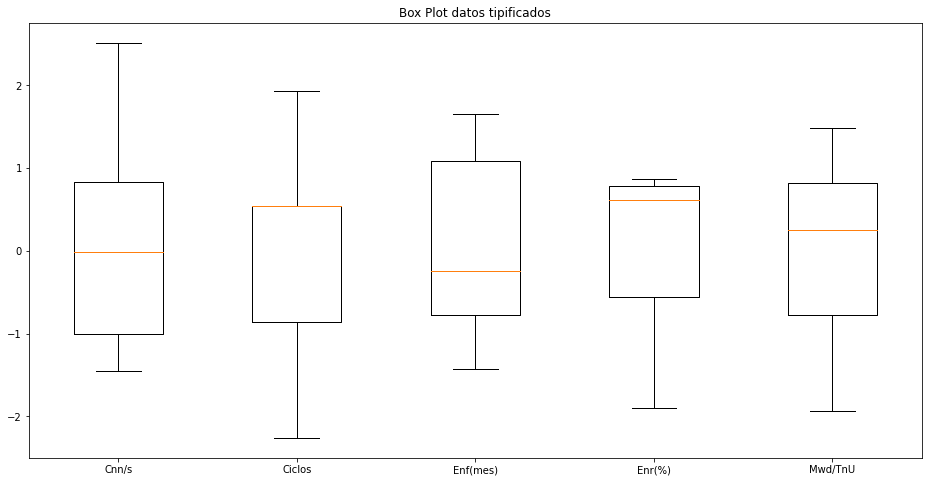

In [6]:
import matplotlib.pyplot as plt

fig1, ax1 = plt.subplots(figsize=(16,8))
ax1.set_title('Box Plot datos tipificados')
ax1.boxplot(data.values[:,5:], labels=data.columns.tolist()[5:])
plt.show()

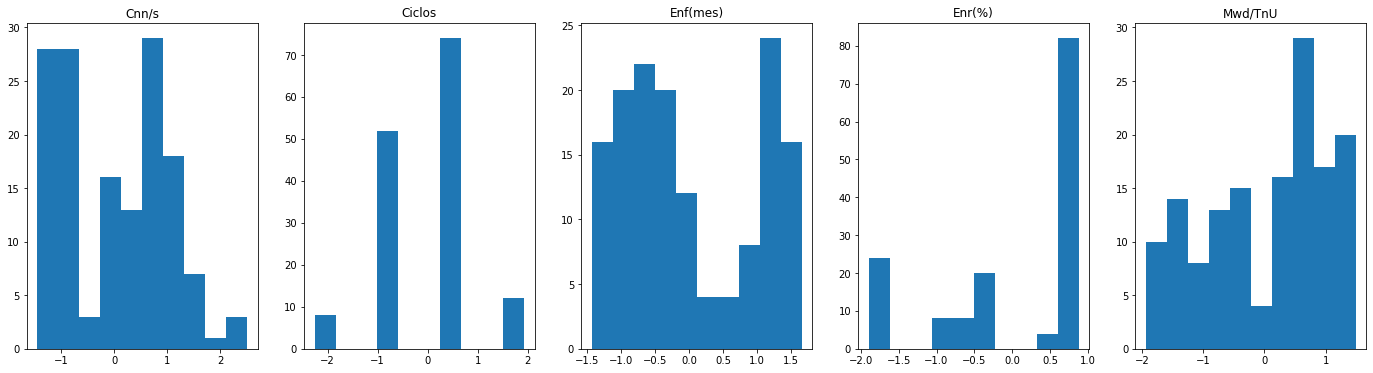

In [7]:
# Diagramas de las variables tipificadas
fig2,ax2 = plt.subplots(1,5,figsize=(24,6))
variables = data.columns.tolist()[5:]
for a,var in enumerate(variables):
    ax2[a].hist(data[var].values)
    ax2[a].set_title(var)
    a+1
plt.show()
plt.close()

In [8]:
# Discretizo para visualizar después los datos según rangos de estas variables.
# Elijo el número de intervalos según las modas en la distribución.
enfriDis = KBinsDiscretizer(n_bins=2, encode='ordinal', strategy='kmeans').fit_transform(df[['Enf(mes)']])
enriqDis = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='kmeans').fit_transform(df[['Enr(%)']])

# Añado las variables discretas al dataframe
data['Ciclos_D'] = df['Ciclos'].astype(float)
data['Enf(mes)_D'] = enfriDis
data['Enr(%)_D'] = enriqDis

data.head()

,EECC,Muestra,MAEF,OFA,STD,Cnn/s,Ciclos,Enf(mes),Enr(%),Mwd/TnU,Ciclos_D,Enf(mes)_D,Enr(%)_D
ind,,,,,,,,,,,,,
1,BL09,1,1,0,0,-0.103873,0.536875,-0.602062,0.871258,0.273655,3.0,0.0,2.0
2,BL09,2,1,0,0,0.218885,0.536875,-0.602062,0.871258,0.532389,3.0,0.0,2.0
3,BL09,3,1,0,0,0.258954,0.536875,-0.602062,0.871258,0.562256,3.0,0.0,2.0
4,BL09,4,1,0,0,-0.199524,0.536875,-0.602062,0.871258,0.189741,3.0,0.0,2.0
5,BL09,5,1,0,0,-0.144162,0.536875,-0.602062,0.871258,0.238809,3.0,0.0,2.0


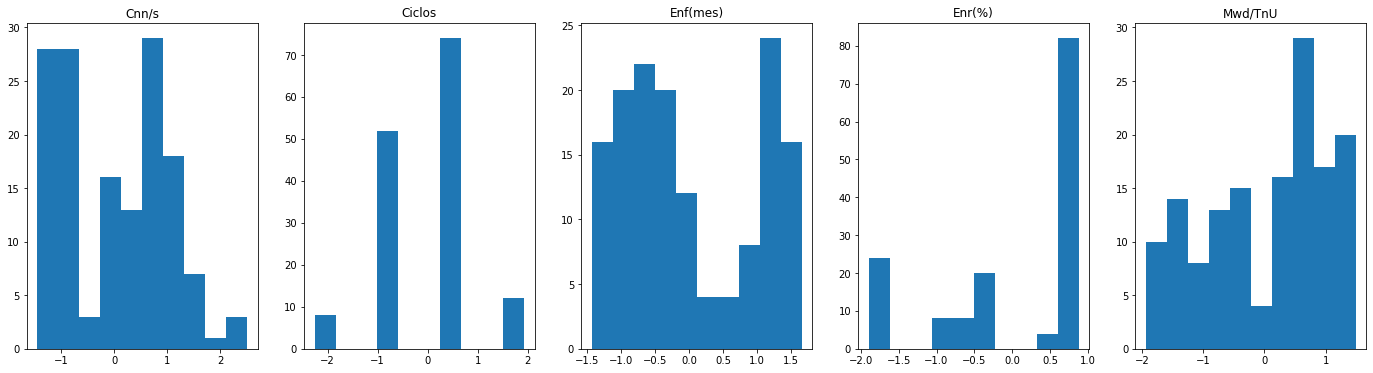

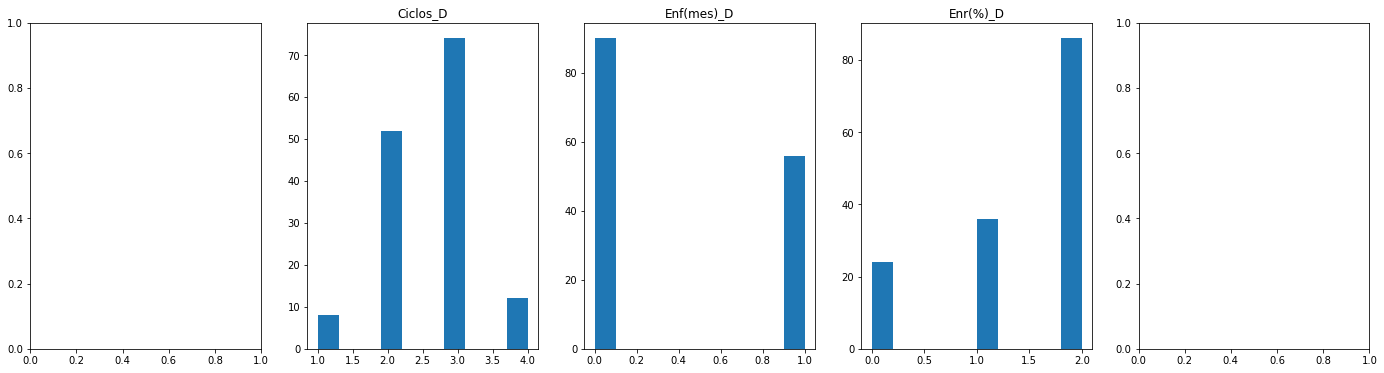

In [9]:
# Diagramas de las variables tipificadas
fig3,ax3 = plt.subplots(1,5,figsize=(24,6))
variables = data.columns.tolist()[5:10]
for a,var in enumerate(variables):
    ax3[a].hist(data[var].values)
    ax3[a].set_title(var)
    a+1

# Diagramas de las variables discretizadas
fig4,ax4 = plt.subplots(1,5,figsize=(24,6))
variables = data.columns.tolist()[10:]
for a,var in enumerate(variables):
    ax4[a+1].hist(data[var].values)
    ax4[a+1].set_title(var)
    a+1

plt.show()
plt.close()

### Coeficiente de correlación entre Cnn/s y Mwd/TnU

In [10]:
# Creo otro data frame con los logaritmos de las variables explicativas y después lo tipifico
dataL = df.copy()
for column in dataL.columns[-5:-1]:
    dataL[column] = np.log(dataL[column])
    dataL[column] = stats.zscore(dataL[column])
dataL['Mwd/TnU'] = stats.zscore(dataL['Mwd/TnU'])

dataL.head()

,EECC,Muestra,MAEF,OFA,STD,Cnn/s,Ciclos,Enf(mes),Enr(%),Mwd/TnU
ind,,,,,,,,,,
1,BL09,1,1,0,0,0.222986,0.575895,-0.344845,0.79487,0.273655
2,BL09,2,1,0,0,0.470416,0.575895,-0.344845,0.79487,0.532389
3,BL09,3,1,0,0,0.498225,0.575895,-0.344845,0.79487,0.562256
4,BL09,4,1,0,0,0.140130,0.575895,-0.344845,0.79487,0.189741
5,BL09,5,1,0,0,0.188697,0.575895,-0.344845,0.79487,0.238809


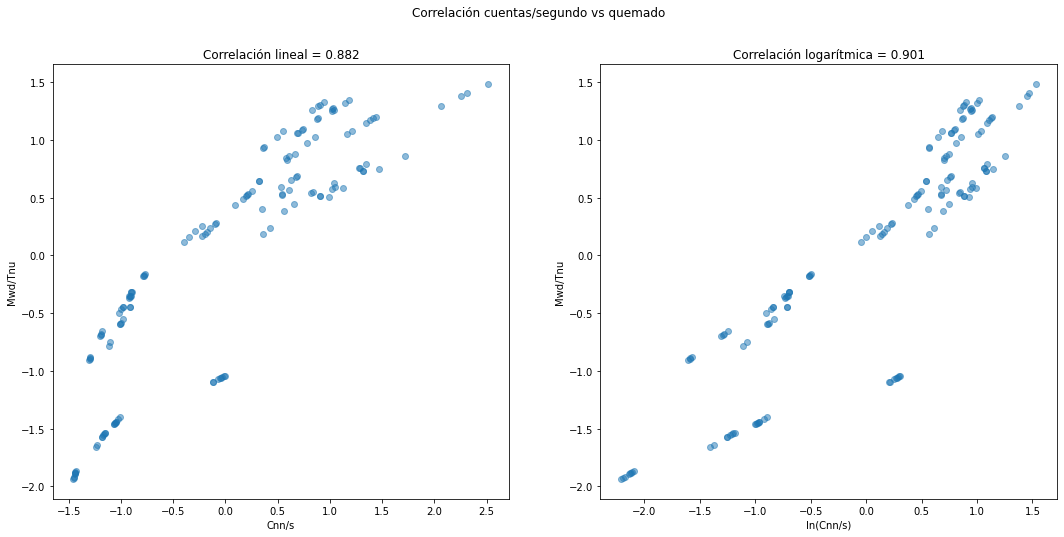

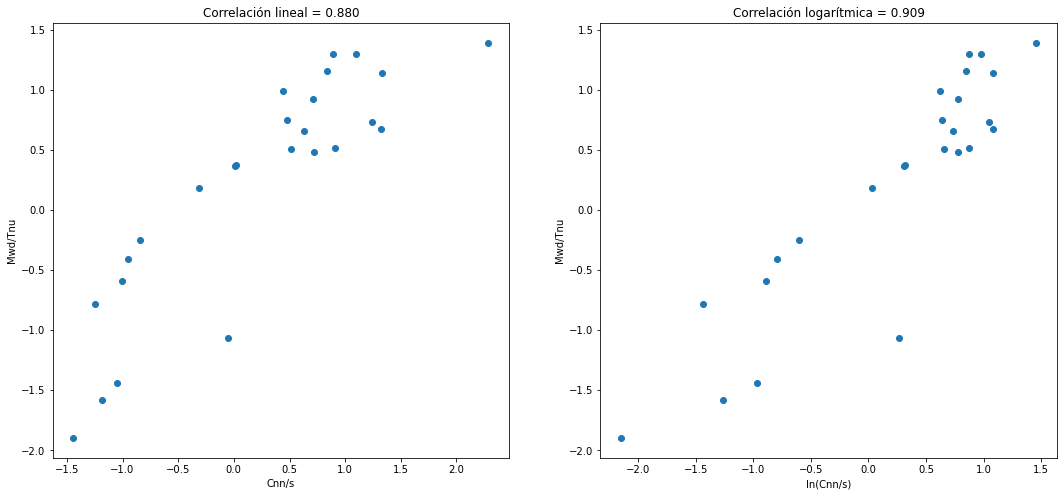

In [11]:
indep = data['Cnn/s'].values
indepL = dataL['Cnn/s'].values
dep = data['Mwd/TnU'].values


corrcoef = np.corrcoef(indep, dep)
corrcoefL = np.corrcoef(indepL, dep)


fig,ax = plt.subplots(1, 2, figsize=(18,8))

ax[0].plot(indep, dep, 'o', alpha=0.5)
ax[0].set_title('Correlación lineal = {:.3f}'.format(corrcoef[0,1]))
ax[0].set_xlabel('Cnn/s')
ax[0].set_ylabel('Mwd/Tnu')

ax[1].plot(indepL, dep, 'o', alpha=0.5)
ax[1].set_title('Correlación logarítmica = {:.3f}'.format(corrcoefL[0,1]))
ax[1].set_xlabel('ln(Cnn/s)')
ax[1].set_ylabel('Mwd/Tnu')


# Para visualizar los datos por EECC en lugar de por caras:
dataEECC = data.groupby(['EECC']).mean().drop(['Muestra'], axis=1)
dataLEECC = dataL.groupby(['EECC']).mean().drop(['Muestra'], axis=1)
# dfEECC.info()

indepEECC = dataEECC['Cnn/s'].values
indepLEECC = dataLEECC['Cnn/s'].values
depEECC = dataEECC['Mwd/TnU'].values

corrcoef = np.corrcoef(indepEECC,depEECC)
corrcoefL = np.corrcoef(indepLEECC,depEECC)


figEECC,axEECC = plt.subplots(1, 2, figsize=(18,8))

axEECC[0].plot(indepEECC, depEECC, 'o')
axEECC[0].set_title('Correlación lineal = {:.3f}'.format(corrcoef[0,1]))
axEECC[0].set_xlabel('Cnn/s')
axEECC[0].set_ylabel('Mwd/Tnu')

axEECC[1].plot(indepLEECC, depEECC, 'o')
axEECC[1].set_title('Correlación logarítmica = {:.3f}'.format(corrcoefL[0,1]))
axEECC[1].set_xlabel('ln(Cnn/s)')
axEECC[1].set_ylabel('Mwd/Tnu')

fig.suptitle('Correlación cuentas/segundo vs quemado')

plt.show()
plt.close()

### Tengo 3 data frames:

df     -->  data frame original

data   -->  data frame tipificado

dataL  -->  data frame logarítmico tipificado

### Mínimos cuadrados:  $\beta = (X^{T}X)^{-1}X^{T}Y$

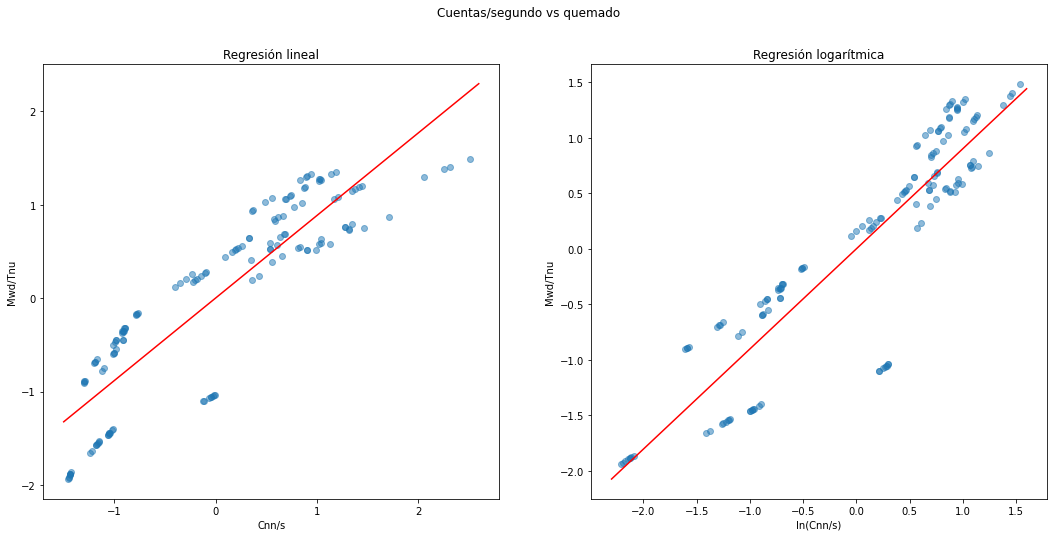

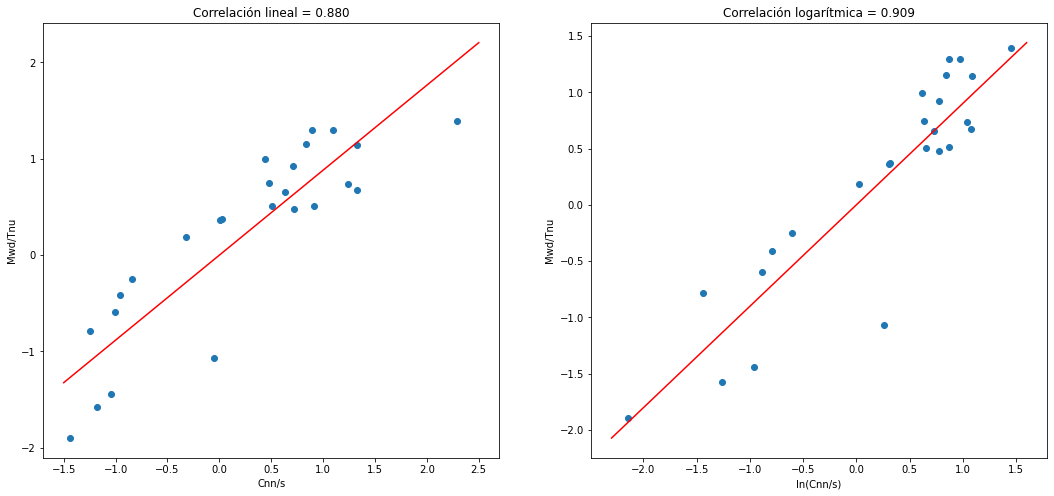

In [12]:
# Incluyo término independiente
X = np.array([np.ones(data['Cnn/s'].shape[0]), data['Cnn/s']]).T
B = np.linalg.inv(X.T @ X) @ X.T @ data['Mwd/TnU']
XL = np.array([np.ones(dataL['Cnn/s'].shape[0]), dataL['Cnn/s']]).T
BL = np.linalg.inv(XL.T @ XL) @ XL.T @ dataL['Mwd/TnU']
# print(B)
# print(BL)

# print(data['Cnn/s'].min(), data['Cnn/s'].max())
# print(dataL['Cnn/s'].min(), dataL['Cnn/s'].max())

# Gráficas incluyendo la línea de regresión
fig,ax = plt.subplots(1, 2, figsize=(18,8))

ax[0].plot(indep, dep, 'o', alpha=0.5)
ax[0].set_title('Regresión lineal')
ax[0].set_xlabel('Cnn/s')
ax[0].set_ylabel('Mwd/Tnu')
ax[0].plot([-1.5, 2.6], [B[0]+B[1]*(-1.5), B[0]+B[1]*2.6], c='red')

ax[1].plot(indepL, dep, 'o', alpha=0.5)
ax[1].set_title('Regresión logarítmica')
ax[1].set_xlabel('ln(Cnn/s)')
ax[1].set_ylabel('Mwd/Tnu')
ax[1].plot([-2.3, 1.6], [BL[0]+BL[1]*(-2.3), BL[0]+BL[1]*1.6], c='red')

figEECC,axEECC = plt.subplots(1, 2, figsize=(18,8))

axEECC[0].plot(indepEECC, depEECC, 'o')
axEECC[0].set_title('Correlación lineal = {:.3f}'.format(corrcoef[0,1]))
axEECC[0].set_xlabel('Cnn/s')
axEECC[0].set_ylabel('Mwd/Tnu')
axEECC[0].plot([-1.5, 2.5], [B[0]+B[1]*(-1.5), B[0]+B[1]*2.5], c='red')

axEECC[1].plot(indepLEECC, depEECC, 'o')
axEECC[1].set_title('Correlación logarítmica = {:.3f}'.format(corrcoefL[0,1]))
axEECC[1].set_xlabel('ln(Cnn/s)')
axEECC[1].set_ylabel('Mwd/Tnu')
axEECC[1].plot([-2.3, 1.6], [BL[0]+BL[1]*(-2.3), BL[0]+BL[1]*1.6], c='red')

fig.suptitle('Cuentas/segundo vs quemado')

plt.show()
plt.close()

### Correlación separando por colores según las demás variables

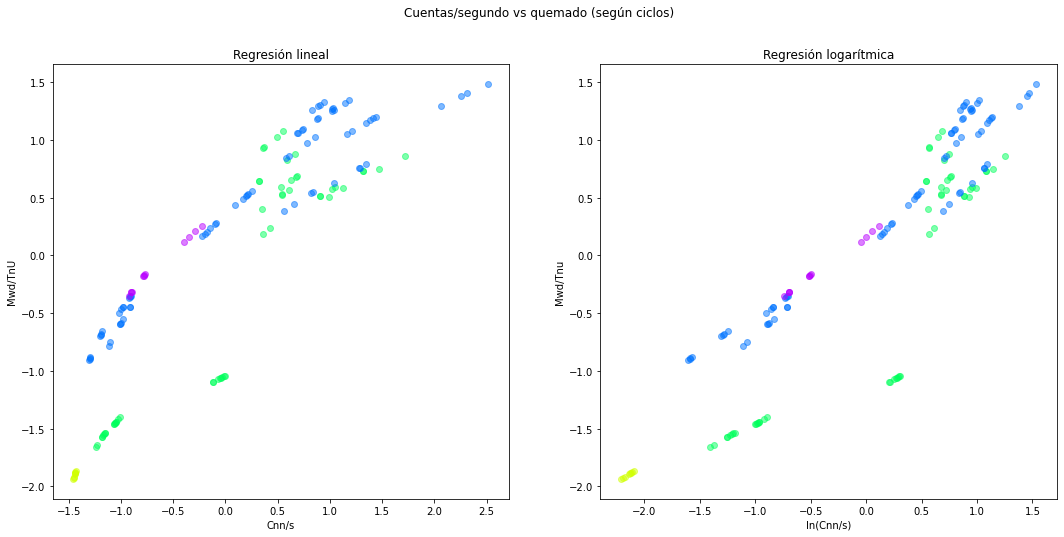

In [13]:
import matplotlib

cmap = matplotlib.cm.get_cmap('hsv')

fig,ax = plt.subplots(1, 2, figsize=(18,8))
colores = int(np.amax(data['Ciclos_D'].values)+1)

for i in range(colores):
    indep = data['Cnn/s'].loc[data['Ciclos_D']==i].values
    indepL = dataL['Cnn/s'].loc[data['Ciclos_D']==i].values
    dep = data['Mwd/TnU'].loc[data['Ciclos_D']==i].values
    ax[0].plot(indep,dep, 'o', alpha=0.5, c=cmap(i/colores))
    ax[1].plot(indepL,dep, 'o', alpha=0.5, c=cmap(i/colores))
    
ax[0].set_title('Regresión lineal')
ax[0].set_xlabel('Cnn/s')
ax[0].set_ylabel('Mwd/TnU')

ax[1].set_title('Regresión logarítmica')
ax[1].set_xlabel('ln(Cnn/s)')
ax[1].set_ylabel('Mwd/Tnu')

fig.suptitle('Cuentas/segundo vs quemado (según ciclos)')

plt.show()
plt.close()

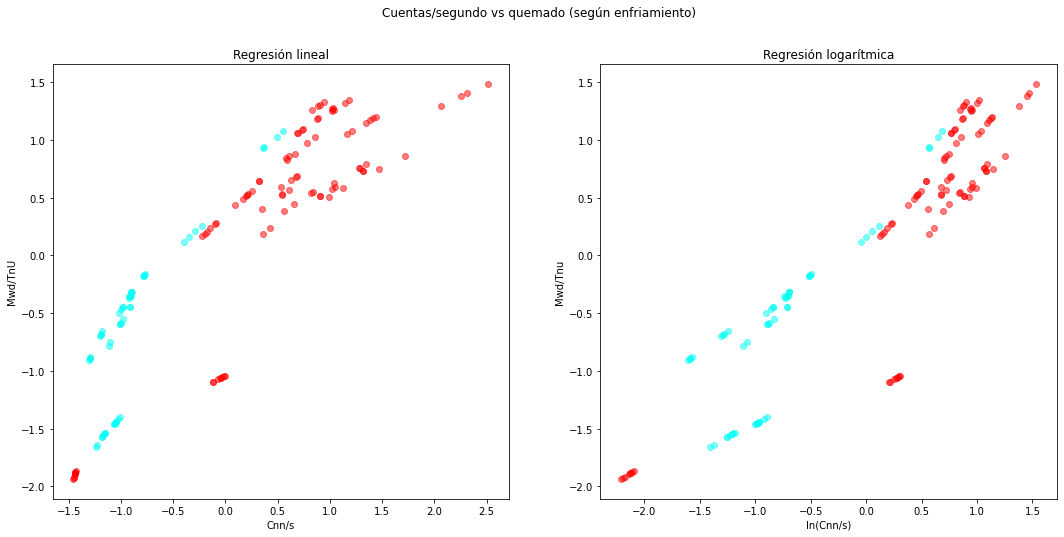

In [14]:
fig,ax = plt.subplots(1, 2, figsize=(18,8))
colores = int(np.amax(data['Enf(mes)_D'].values)+1)

for i in range(colores):
    indep = data['Cnn/s'].loc[data['Enf(mes)_D']==i].values
    indepL = dataL['Cnn/s'].loc[data['Enf(mes)_D']==i].values
    dep = data['Mwd/TnU'].loc[data['Enf(mes)_D']==i].values
    ax[0].plot(indep,dep, 'o', alpha=0.5, c=cmap(i/colores))
    ax[1].plot(indepL,dep, 'o', alpha=0.5, c=cmap(i/colores))
    
ax[0].set_title('Regresión lineal')
ax[0].set_xlabel('Cnn/s')
ax[0].set_ylabel('Mwd/TnU')

ax[1].set_title('Regresión logarítmica')
ax[1].set_xlabel('ln(Cnn/s)')
ax[1].set_ylabel('Mwd/Tnu')

fig.suptitle('Cuentas/segundo vs quemado (según enfriamiento)')

plt.show()
plt.close()

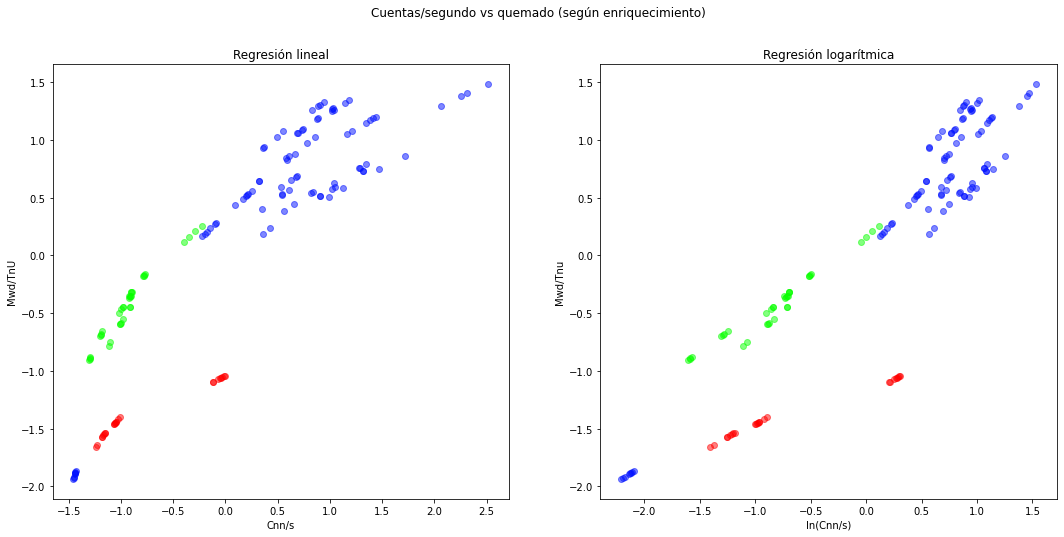

In [15]:
fig,ax = plt.subplots(1, 2, figsize=(18,8))
colores = int(np.amax(data['Enr(%)_D'].values)+1)

for i in range(colores):
    indep = data['Cnn/s'].loc[data['Enr(%)_D']==i].values
    indepL = dataL['Cnn/s'].loc[data['Enr(%)_D']==i].values
    dep = data['Mwd/TnU'].loc[data['Enr(%)_D']==i].values
    ax[0].plot(indep,dep, 'o', alpha=0.5, c=cmap(i/colores))
    ax[1].plot(indepL,dep, 'o', alpha=0.5, c=cmap(i/colores))

ax[0].set_title('Regresión lineal')
ax[0].set_xlabel('Cnn/s')
ax[0].set_ylabel('Mwd/TnU')

ax[1].set_title('Regresión logarítmica')
ax[1].set_xlabel('ln(Cnn/s)')
ax[1].set_ylabel('Mwd/Tnu')

fig.suptitle('Cuentas/segundo vs quemado (según enriquecimiento)')

plt.show()
plt.close()

### Mínimos cuadrados con todas las variables: $\beta = (X^{T}X)^{-1}X^{T}Y$

In [16]:
X = np.array([np.ones(data['Cnn/s'].shape[0]), data['Cnn/s'], \
              data['Ciclos'], data['Enf(mes)'], data['Enr(%)']]).T
B = np.linalg.inv(X.T @ X) @ X.T @ data['Mwd/TnU']
XL = np.array([np.ones(dataL['Cnn/s'].shape[0]), dataL['Cnn/s'], \
               dataL['Ciclos'], dataL['Enf(mes)'], dataL['Enr(%)']]).T
BL = np.linalg.inv(XL.T @ XL) @ XL.T @ dataL['Mwd/TnU']

print(B)
print()
print(BL)

[4.345e-16 8.662e-01 1.011e-01 4.736e-01 5.258e-01]

[-4.207e-16  7.880e-01  4.613e-02  3.289e-01  5.219e-01]


Entonces:

$Mwd/Tnu \; = \; B[0] + B[1] \cdot Cnn/s + B[2] \cdot Ciclos + B[3] \cdot Enf(mes) + B[4] \cdot Enr(\%)$

$Mwd/Tnu \; = \; BL[0] + BL[1] \cdot \ln(Cnn/s) + BL[2] \cdot \ln(Ciclos) + BL[3] \cdot \ln(Enf(mes)) + BL[4] \cdot \ln(Enr(\%))$

# Método LOOCV (Leave One Out Cross Validation)

In [17]:
# df.head()

In [18]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


# Creo nuevos dataframes vacíos, donde iré guardando los resultados de cada iteración.
LOOCV = pd.DataFrame(columns=['Excluido', 'Predicción', 'Validación', 'Error'])
LOOCVL = pd.DataFrame(columns=['Excluido', 'Predicción', 'Validación', 'Error'])

# Hago una lista con la identificación de cada elemento
lista = data['EECC'].unique().tolist()
# print(lista)

# En cada bucle separo las 4 u 8 medidas de un elemento en "valid" y el resto de medidas las guardo en "entren"
# para hacer las regresiones con ellas, y voy almacenando los resultados en los nuevos dataframes.
agrupa = data.groupby(data.EECC)
agrupaL = dataL.groupby(dataL.EECC)

for excluido in lista:
    # print(excluido)

    valid = agrupa.get_group(excluido)
    valid = np.mean(valid.values[:,5:10], axis=0)
    entren = data[data.EECC != excluido]
    # print(valid)
    # print(entren)
    validL = agrupaL.get_group(excluido)
    validL = np.mean(validL.values[:,5:], axis=0)
    entrenL = dataL[dataL.EECC != excluido]
    # print(validL)
    # print(entrenL)

    X = np.array([np.ones(entren['Cnn/s'].shape[0]), entren['Cnn/s'], \
                  entren['Ciclos'], entren['Enf(mes)'], entren['Enr(%)']]).T
    B = np.linalg.inv(X.T @ X) @ X.T @ entren['Mwd/TnU']
    
    XL = np.array([np.ones(entrenL['Cnn/s'].shape[0]), entrenL['Cnn/s'], \
                   entrenL['Ciclos'], entrenL['Enf(mes)'], entrenL['Enr(%)']]).T
    BL = np.linalg.inv(XL.T @ XL) @ XL.T @ entrenL['Mwd/TnU']

    
    sol = valid[4]
    calc = B[0]+B[1]*valid[0]+B[2]*valid[1]+B[3]*valid[2]+B[4]*valid[3]
    error = ((calc - sol)/sol)*100
    # print('{0:.2f} %'.format(error))
    solL = validL[4]
    calcL = BL[0]+BL[1]*validL[0]+BL[2]*validL[1]+BL[3]*validL[2]+BL[4]*validL[3]
    errorL = ((calcL - solL)/solL)*100
    # print('{0:.2f} %'.format(errorL))
    
    
    LOOCV = LOOCV.append({'Excluido': excluido, 'Predicción': calc, 'Validación': sol, \
                          'Error': '{0:.2f}%'.format(error)}, ignore_index = True)
    
    LOOCVL = LOOCVL.append({'Excluido': excluido, 'Predicción': calcL, 'Validación': solL, \
                                'Error': '{0:.2f}%'.format(errorL)}, ignore_index = True)


print('REGRESIÓN LINEAL')
display(LOOCV)
print()
rmse = mean_squared_error(LOOCV.values[:,2], LOOCV.values[:,1], squared = False)
print('RMSE =', '{0:.2f}'.format(rmse))
print()
mae = mean_absolute_error(LOOCV.values[:,2], LOOCV.values[:,1])
print('MAE =', '{0:.2f}'.format(mae))
print()
print()
print()

print('REGRESIÓN LOGARÍTMICA')
display(LOOCVL)
print()
rmse = mean_squared_error(LOOCVL.values[:,2], LOOCVL.values[:,1], squared = False)
print('RMSE =', '{0:.2f}'.format(rmse))
print()
mae = mean_absolute_error(LOOCVL.values[:,2], LOOCVL.values[:,1])
print('MAE =', '{0:.2f}'.format(mae))

REGRESIÓN LINEAL


,Excluido,Predicción,Validación,Error
0,BL09,0.214449,0.371791,-42.32%
1,BT18,0.783182,0.676038,15.85%
2,BR03,0.890665,0.734825,21.21%
3,BP08,2.099059,1.391645,50.83%
4,BM09,1.317191,1.141534,15.39%
5,BK49,0.875361,0.925823,-5.45%
6,BJ12,1.327539,1.295909,2.44%
7,BH08,1.033677,1.154497,-10.47%
8,BS40,-1.181718,-1.898310,-37.75%
9,BS19,0.444042,0.511959,-13.27%



RMSE = 0.26

MAE = 0.19



REGRESIÓN LOGARÍTMICA


,Excluido,Predicción,Validación,Error
0,BL09,0.604096,0.371791,62.48%
1,BT18,0.403867,0.676038,-40.26%
2,BR03,0.630933,0.734825,-14.14%
3,BP08,1.165919,1.391645,-16.22%
4,BM09,1.100487,1.141534,-3.60%
5,BK49,0.980111,0.925823,5.86%
6,BJ12,1.209467,1.295909,-6.67%
7,BH08,1.062224,1.154497,-7.99%
8,BS40,-1.910217,-1.898310,0.63%
9,BS19,0.452957,0.511959,-11.52%



RMSE = 0.16

MAE = 0.13


# Regresión con Random Forest

In [19]:
# data.head()

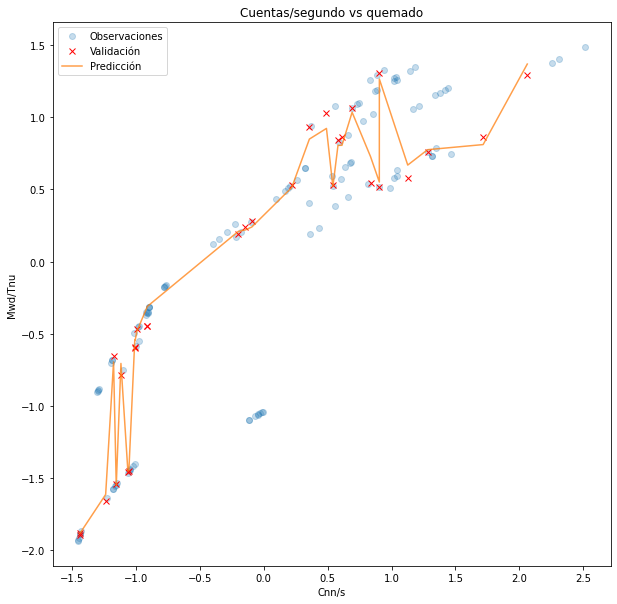

,Cnn/s_val,Mwd/TnU_val,Mwd/TnU_pred,Error
0,-1.441000,-1.895776,-1.881299,-0.76%
1,-1.434972,-1.878827,-1.876643,-0.12%
2,-1.237862,-1.659798,-1.613186,-2.81%
3,-1.175957,-0.656982,-0.695141,5.81%
4,-1.154856,-1.540683,-1.550345,0.63%
5,-1.118243,-0.783089,-0.705020,-9.97%
6,-1.063911,-1.459970,-1.450771,-0.63%
7,-1.056044,-1.450607,-1.447559,-0.21%
8,-1.009652,-0.596891,-0.540657,-9.42%
9,-1.006197,-0.591320,-0.542413,-8.27%


Precisión del entrenamiento = 99.89%
Precisión de la validación = 99.56%

RMSE = 0.07

MAE = 0.05


In [20]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor


# X almacena las variables independientes
# Y almacena la variable dependiente
X = data.iloc[:, 5:9].values
Y = data.iloc[:, 9].values
# print(X)
# print(Y)

# División de los datos en conjuntos de entrenamiento y validación
Xent, Xval, Yent, Yval = train_test_split(X, Y, test_size = 0.2)
# print(len(Xent), len(Yent))
# print(len(Xval), len(Yval))

# Aplicar el algoritmo y entrenar
bosque = RandomForestRegressor(n_estimators = 2000, max_depth = 6)
bosque.fit(Xent, Yent)

# Predicción
Ypred = bosque.predict(Xval)

# Error relativo
Error = pd.DataFrame(columns=['Error'])
for n in range(len(Ypred)):
    error = ((Ypred[n] - Yval[n])/Yval[n])*100
    Error = Error.append({'Error': '{0:.2f}%'.format(error)}, ignore_index = True)


# Ordeno los valores de menor a mayor abscisa para que la representación se vea mejor
Pred = pd.DataFrame({'Cnn/s_val': Xval[:, 0], 'Mwd/TnU_val': Yval, 'Mwd/TnU_pred': Ypred, 'Error': Error['Error']})
Pred = Pred.sort_values('Cnn/s_val')
Pred = Pred.reset_index(drop=True)

fig,ax = plt.subplots(figsize=(10,10))
ax.plot(Xent[:, 0], Yent, 'o', alpha=0.25, label='Observaciones')
ax.plot(Pred['Cnn/s_val'], Pred['Mwd/TnU_val'], 'x', color='red', label='Validación')
ax.plot(Pred['Cnn/s_val'], Pred['Mwd/TnU_pred'], alpha=0.75, label='Predicción')
ax.set_title('Cuentas/segundo vs quemado')
ax.set_xlabel('Cnn/s')
ax.set_ylabel('Mwd/Tnu')
ax.legend(fontsize=10)
plt.show()
plt.close()


display(Pred)

precEnt = bosque.score(Xent, Yent)
precVal = bosque.score(Xval, Yval)
print('Precisión del entrenamiento =', '{0:.2f}%'.format(100*precEnt))
print('Precisión de la validación =', '{0:.2f}%'.format(100*precVal))
print()
rmse = mean_squared_error(Yval, Ypred, squared = False)
print('RMSE =', '{0:.2f}'.format(rmse))
print()
mae = mean_absolute_error(Yval, Ypred)
print('MAE =', '{0:.2f}'.format(mae))

Los resultados son tan extraordinariamente buenos porque he hecho completamente aleatoria la división de los conjuntos de entrenamiento y valicación, y hay datos de un mismo elemento en los dos conjuntos que son prácticamente idénticos.

Estoy validando prácticamente con los mimos datos con los que entreno.

### Repito la regresión separando en el conjunto de validación los datos completos de 5 elementos aleatorios

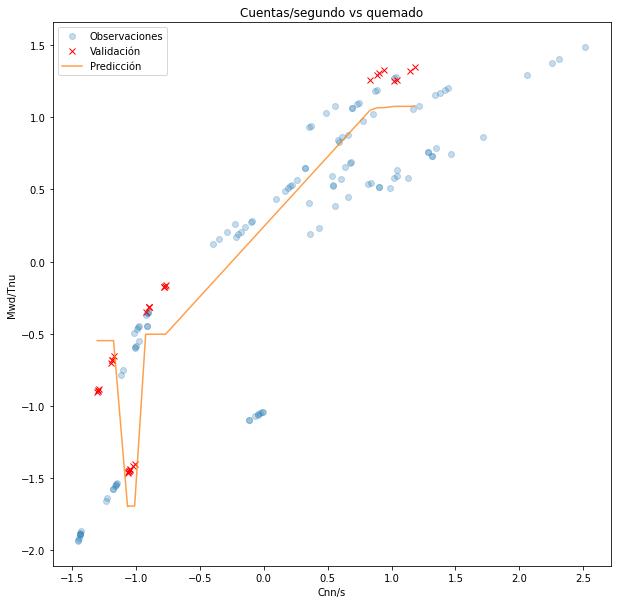

,Cnn/s_val,Mwd/TnU_val,Mwd/TnU_pred,Error
0,-1.303516,-0.905760,-0.547054,-39.60%
1,-1.298075,-0.893908,-0.547054,-38.80%
2,-1.296826,-0.891300,-0.547054,-38.62%
3,-1.292855,-0.882885,-0.547054,-38.04%
4,-1.199557,-0.699294,-0.547054,-21.77%
5,-1.191396,-0.684479,-0.547054,-20.08%
6,-1.190000,-0.681990,-0.547054,-19.79%
7,-1.175957,-0.656982,-0.547054,-16.73%
8,-1.066705,-1.463288,-1.695853,15.89%
9,-1.063911,-1.459970,-1.695853,16.16%


Precisión del entrenamiento = 98.51%
Precisión de la validación = 93.73%

RMSE = 0.25

MAE = 0.24


In [28]:
# Hago una lista con la identificación de cada elemento
lista = data['EECC'].unique().tolist()
# print(lista)

# Selecciono 5 elementos aleatorios y los separo, para generar un data frame de validación y otro de entrenamiento
random = np.random.choice(a=len(lista), size=5, replace=False)
# print(random)
valid = pd.DataFrame()
agrupa = data.groupby(data.EECC)
for excluidos in random:
    val = agrupa.get_group(lista[excluidos])
    valid = valid.append(val)
entren = data.drop(valid.index)
# print(valid)
# print(entren)


# Repito el proceso anterior
Xent = entren.iloc[:, 5:9].values
Xval = valid.iloc[:, 5:9].values
Yent = entren.iloc[:, 9].values
Yval = valid.iloc[:, 9].values

# Aplicar el algoritmo y entrenar
bosque = RandomForestRegressor(n_estimators = 100, max_depth = 3)
bosque.fit(Xent, Yent)
'''
EN PRINCIPIO CUANTOS MÁS ÁRBOLES MEJOR, PERO NO HE VISTO DIFERENCIA SIGNITICATIVA EN UN RANGO DE ENTRE 200 A 50000.
TAMPOCO APRECIO DIFERENCIAS ENTRE PROFUNDIADES DE VALOR ENTRE 4 Y 12.
¿HAY ALGÚN MODO DE ELEGIR EL NÚMERO DE ESTIMADORES Y DE PROFUNDIDAD MÁS ÓPTIMOS?
'''

# Predicción
Ypred = bosque.predict(Xval)

# Error relativo
Error = pd.DataFrame(columns=['Error'])
for n in range(len(Ypred)):
    error = ((Ypred[n] - Yval[n])/Yval[n])*100
    Error = Error.append({'Error': '{0:.2f}%'.format(error)}, ignore_index = True)


# Ordeno los valores de menor a mayor abscisa para que la representación se vea mejor
Pred = pd.DataFrame({'Cnn/s_val': Xval[:, 0], 'Mwd/TnU_val': Yval, 'Mwd/TnU_pred': Ypred, 'Error': Error['Error']})
Pred = Pred.sort_values('Cnn/s_val')
Pred = Pred.reset_index(drop=True)

fig,ax = plt.subplots(figsize=(10,10))
ax.plot(Xent[:, 0], Yent, 'o', alpha=0.25, label='Observaciones')
ax.plot(Pred['Cnn/s_val'], Pred['Mwd/TnU_val'], 'x', color='red', label='Validación')
ax.plot(Pred['Cnn/s_val'], Pred['Mwd/TnU_pred'], alpha=0.75, label='Predicción')
ax.set_title('Cuentas/segundo vs quemado')
ax.set_xlabel('Cnn/s')
ax.set_ylabel('Mwd/Tnu')
ax.legend(fontsize=10)
plt.show()
plt.close()


display(Pred)

precEnt = bosque.score(Xent, Yent)
precVal = bosque.score(Xval, Yval)
print('Precisión del entrenamiento =', '{0:.2f}%'.format(100*precEnt))
print('Precisión de la validación =', '{0:.2f}%'.format(100*precVal))
print()
rmse = mean_squared_error(Yval, Ypred, squared = False)
print('RMSE =', '{0:.2f}'.format(rmse))
print()
mae = mean_absolute_error(Yval, Ypred)
print('MAE =', '{0:.2f}'.format(mae))

#### Algunas veces hace buenas predicciones y otras tiene una precisión malísima

### Repito la regresión separando en el conjunto de validación los datos completos de 1 solo elemento aleatorio

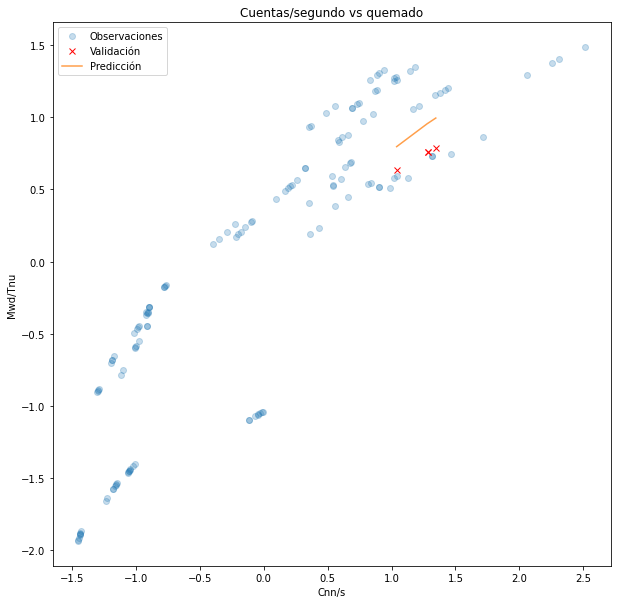

,Cnn/s_val,Mwd/TnU_val,Mwd/TnU_pred,Error
0,1.040262,0.631948,0.796743,26.08%
1,1.282661,0.758292,0.957702,26.30%
2,1.283396,0.758648,0.957702,26.24%
3,1.346698,0.790412,0.994945,25.88%


Precisión del entrenamiento = 99.97%
Precisión de la validación = -903.11%

RMSE = 0.19

MAE = 0.19


In [29]:
# Hago una lista con la identificación de cada elemento
lista = data['EECC'].unique().tolist()
# print(lista)

# Selecciono 1 elemento aleatorio y lo separo, para generar un data frame de validación y otro de entrenamiento.
excluido = np.random.choice(a=len(lista), size=1)
agrupa = data.groupby(data.EECC)
valid = agrupa.get_group(lista[int(excluido)])
valid = pd.DataFrame(valid)
entren = data.drop(valid.index)
# print(valid)
# print(entren)


# Repito el proceso anterior
Xent = entren.iloc[:, 5:9].values
Xval = valid.iloc[:, 5:9].values
Yent = entren.iloc[:, 9].values
Yval = valid.iloc[:, 9].values

# Aplicar el algoritmo y entrenar
bosque = RandomForestRegressor(n_estimators = 4000, max_depth = 10)
bosque.fit(Xent, Yent)

# Predicción
Ypred = bosque.predict(Xval)

# Error relativo
Error = pd.DataFrame(columns=['Error'])
for n in range(len(Ypred)):
    error = ((Ypred[n] - Yval[n])/Yval[n])*100
    Error = Error.append({'Error': '{0:.2f}%'.format(error)}, ignore_index = True)


# Ordeno los valores de menor a mayor abscisa para que la representación se vea mejor
Pred = pd.DataFrame({'Cnn/s_val': Xval[:, 0], 'Mwd/TnU_val': Yval, 'Mwd/TnU_pred': Ypred, 'Error': Error['Error']})
Pred = Pred.sort_values('Cnn/s_val')
Pred = Pred.reset_index(drop=True)

fig,ax = plt.subplots(figsize=(10,10))
ax.plot(Xent[:, 0], Yent, 'o', alpha=0.25, label='Observaciones')
ax.plot(Pred['Cnn/s_val'], Pred['Mwd/TnU_val'], 'x', color='red', label='Validación')
ax.plot(Pred['Cnn/s_val'], Pred['Mwd/TnU_pred'], alpha=0.75, label='Predicción')
ax.set_title('Cuentas/segundo vs quemado')
ax.set_xlabel('Cnn/s')
ax.set_ylabel('Mwd/Tnu')
ax.legend(fontsize=10)
plt.show()
plt.close()


display(Pred)

precEnt = bosque.score(Xent, Yent)
precVal = bosque.score(Xval, Yval)
print('Precisión del entrenamiento =', '{0:.2f}%'.format(100*precEnt))
print('Precisión de la validación =', '{0:.2f}%'.format(100*precVal))
print()
rmse = mean_squared_error(Yval, Ypred, squared = False)
print('RMSE =', '{0:.2f}'.format(rmse))
print()
mae = mean_absolute_error(Yval, Ypred)
print('MAE =', '{0:.2f}'.format(mae))

#### La precisión también es muy variable, pero en general es mucho peor.

### Repito la regresión utilizando los datos de los EECC completos just for fun.

In [23]:
# dataEECC.head()

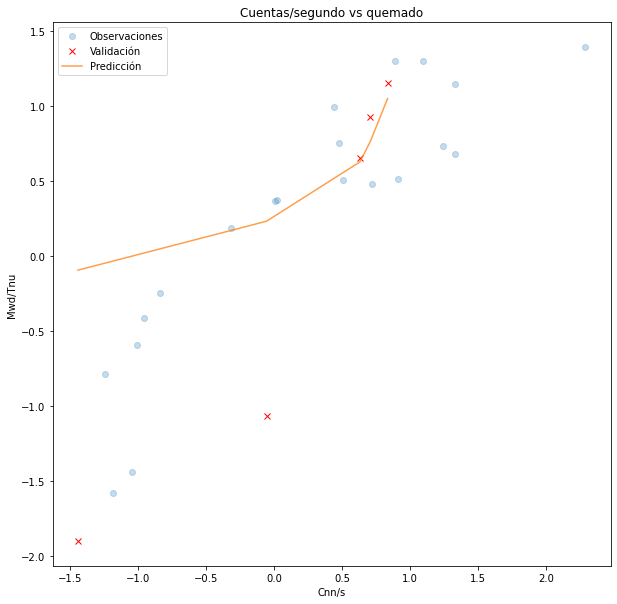

,Cnn/s_val,Mwd/TnU_val,Mwd/TnU_pred,Error
0,-1.441800,-1.898310,-0.094605,-95.02%
1,-0.055652,-1.064683,0.231221,-121.72%
2,0.630750,0.655030,0.626199,-4.40%
3,0.707267,0.925823,0.762188,-17.67%
4,0.833797,1.154497,1.047544,-9.26%


Precisión del entrenamiento = 98.16%
Precisión de la validación = 32.32%

RMSE = 1.00

MAE = 0.68


In [30]:
# X almacena las variables independientes
# Y almacena la variable dependiente
X = dataEECC.iloc[:, 3:7].values
Y = dataEECC.iloc[:, 7].values
# print(X)
# print(Y)

# División de los datos en conjuntos de entrenamiento y validación
Xent, Xval, Yent, Yval = train_test_split(X, Y, test_size = 0.2)
# print(len(Xent), len(Yent))
# print(len(Xval), len(Yval))

# Aplicar el algoritmo y entrenar
bosque = RandomForestRegressor(n_estimators = 5000, max_depth = 4)
bosque.fit(Xent, Yent)

# Predicción
Ypred = bosque.predict(Xval)

# Error relativo
Error = pd.DataFrame(columns=['Error'])
for n in range(len(Ypred)):
    error = ((Ypred[n] - Yval[n])/Yval[n])*100
    Error = Error.append({'Error': '{0:.2f}%'.format(error)}, ignore_index = True)


# Ordeno los valores de menor a mayor abscisa para que la representación se vea mejor
Pred = pd.DataFrame({'Cnn/s_val': Xval[:, 0], 'Mwd/TnU_val': Yval, 'Mwd/TnU_pred': Ypred, 'Error': Error['Error']})
Pred = Pred.sort_values('Cnn/s_val')
Pred = Pred.reset_index(drop=True)

fig,ax = plt.subplots(figsize=(10,10))
ax.plot(Xent[:, 0], Yent, 'o', alpha=0.25, label='Observaciones')
ax.plot(Pred['Cnn/s_val'], Pred['Mwd/TnU_val'], 'x', color='red', label='Validación')
ax.plot(Pred['Cnn/s_val'], Pred['Mwd/TnU_pred'], alpha=0.75, label='Predicción')
ax.set_title('Cuentas/segundo vs quemado')
ax.set_xlabel('Cnn/s')
ax.set_ylabel('Mwd/Tnu')
ax.legend(fontsize=10)
plt.show()
plt.close()


display(Pred)

precEnt = bosque.score(Xent, Yent)
precVal = bosque.score(Xval, Yval)
print('Precisión del entrenamiento =', '{0:.2f}%'.format(100*precEnt))
print('Precisión de la validación =', '{0:.2f}%'.format(100*precVal))
print()
rmse = mean_squared_error(Yval, Ypred, squared = False)
print('RMSE =', '{0:.2f}'.format(rmse))
print()
mae = mean_absolute_error(Yval, Ypred)
print('MAE =', '{0:.2f}'.format(mae))

Parece que la muestra es demasiado pequeña para que puedan hacerse buenas predicciones, al menos con este método.